## Financials Model

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import quandl
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_absolute_error as mae
from functools import reduce

### Load target variable data

In [2]:
# Load P/E ratio -- data manually downloaded from Capital IQ
pe_ratio = pd.read_csv('Normalized_PE.csv')
pe_ratio.head()

,Dates,PE
0,Aug-22-2001,19.587
1,Aug-23-2001,19.501
2,Aug-24-2001,19.573
3,Aug-27-2001,19.393
4,Aug-28-2001,19.124


In [3]:
# load consumer discretionary index price -- also from Capital IQ
price = pd.read_csv('avg_m_price.csv')
price.head()

,Dates,Value
0,Aug-01-2001,379.37
1,Aug-02-2001,380.04
2,Aug-03-2001,379.23
3,Aug-06-2001,375.74
4,Aug-07-2001,377.47


In [4]:
# load 10 year treasury rate
quandl.ApiConfig.api_key = 'AtPuHRXs-rLGozrAYSKk'

treasury = quandl.get("FRED/DGS10")
treasury.head()

,Value
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


### Transform

In [5]:
# rename
pe_ratio = pe_ratio.rename(columns = {"Dates": "Date"})
pe_ratio['Date'] = pd.to_datetime(pe_ratio['Date'])
pe_ratio = pe_ratio.set_index('Date')

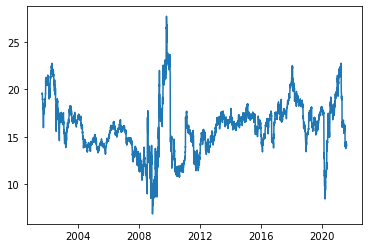

In [6]:
plt.plot(pe_ratio.PE)

In [7]:
# rename, change type
price = price.rename(columns = {"Dates": "Date", "Value" : "Price"})
price['Date'] = pd.to_datetime(price['Date'])
price = price.set_index('Date')

price.head()

,Price
Date,
2001-08-01,379.37
2001-08-02,380.04
2001-08-03,379.23
2001-08-06,375.74
2001-08-07,377.47


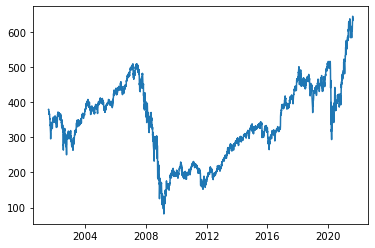

In [8]:
plt.plot(price.Price)

In [9]:
treasury = treasury.rename(columns = {"Value" : "treasury_rate"})
treasury.head()

,treasury_rate
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


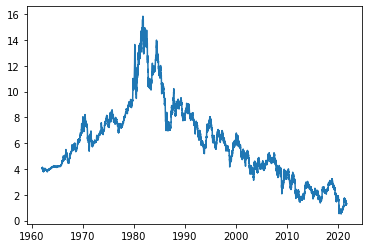

In [10]:
plt.plot(treasury.treasury_rate)

### Transform to monthly average

In [11]:
joined = pe_ratio.join(price).join(treasury)
joined.head(100)

,PE,Price,treasury_rate
Date,,,
2001-08-22,19.587,366.77,4.91
2001-08-23,19.501,365.26,4.89
2001-08-24,19.573,366.06,4.93
2001-08-27,19.393,362.48,4.94
2001-08-28,19.124,357.68,4.85
...,...,...,...
2002-01-14,20.596,350.69,4.91
2002-01-15,21.003,357.56,4.88
2002-01-16,20.729,353.17,4.88


In [12]:
joined['month'] = joined.index.month
joined['year'] = joined.index.year

joined = joined.groupby([joined.year, joined.month]).mean()
joined.head()

PE       Price  treasury_rate
year month                                      
2001 8      19.251125  359.777500       4.867500
     9      17.427800  323.474000       4.748667
     10     18.265739  332.585652       4.566818
     11     20.247286  348.135714       4.651500
     12     20.904150  350.799500       5.087500

In [13]:
joined = joined.reset_index()
joined['date'] = pd.to_datetime(joined[['year', 'month']].assign(DAY=1))
joined = joined.set_index('date')
joined.head()

,year,month,PE,Price,treasury_rate
date,,,,,
2001-08-01,2001,8,19.251125,359.777500,4.867500
2001-09-01,2001,9,17.427800,323.474000,4.748667
2001-10-01,2001,10,18.265739,332.585652,4.566818
2001-11-01,2001,11,20.247286,348.135714,4.651500
2001-12-01,2001,12,20.904150,350.799500,5.087500


In [14]:
joined['earnings'] = joined.Price / joined.PE
joined.head()

,year,month,PE,Price,treasury_rate,earnings
date,,,,,,
2001-08-01,2001,8,19.251125,359.777500,4.867500,18.688648
2001-09-01,2001,9,17.427800,323.474000,4.748667,18.560805
2001-10-01,2001,10,18.265739,332.585652,4.566818,18.208168
2001-11-01,2001,11,20.247286,348.135714,4.651500,17.194192
2001-12-01,2001,12,20.904150,350.799500,5.087500,16.781333


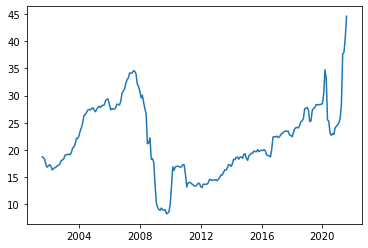

In [15]:
plt.plot(joined.earnings)

In [16]:
joined['earnings_change'] = joined.earnings.pct_change()
display(joined)

,year,month,PE,Price,treasury_rate,earnings,earnings_change
date,,,,,,,
2001-08-01,2001,8,19.251125,359.777500,4.867500,18.688648,NaN
2001-09-01,2001,9,17.427800,323.474000,4.748667,18.560805,-0.006841
2001-10-01,2001,10,18.265739,332.585652,4.566818,18.208168,-0.018999
2001-11-01,2001,11,20.247286,348.135714,4.651500,17.194192,-0.055688
2001-12-01,2001,12,20.904150,350.799500,5.087500,16.781333,-0.024012
...,...,...,...,...,...,...,...
2021-04-01,2021,4,20.529850,586.167500,1.628000,28.551962,0.108924
2021-05-01,2021,5,16.485400,621.002000,1.621000,37.669817,0.319342
2021-06-01,2021,6,16.240895,617.320000,1.524211,38.010221,0.009037


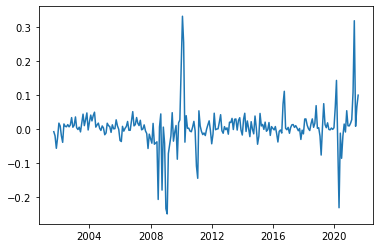

In [17]:
plt.plot(joined.earnings_change)

In [18]:
joined['target'] = joined.earnings_change - ((1 + joined.treasury_rate/100)**(1/12) - 1)
joined = joined.dropna()
joined.head()
joined.dtypes

year                 int64
month                int64
PE                 float64
Price              float64
treasury_rate      float64
earnings           float64
earnings_change    float64
target             float64
dtype: object

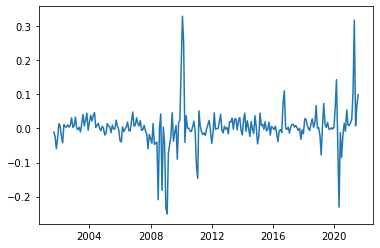

In [19]:
plt.plot(joined.target)

In [20]:
target = joined['target'].to_frame()
target.head()

,target
date,
2001-09-01,-0.010714
2001-10-01,-0.022727
2001-11-01,-0.059484
2001-12-01,-0.028155
2002-01-01,0.014207


In [169]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(target['target'])

In [170]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(target):
    result=adfuller(target)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [171]:
adfuller_test(target['target'])

ADF Test Statistic : -4.348793271783021
p-value : 0.00036529129954764717
#Lags Used : 13
Number of Observations Used : 226
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


## SARIMA Model

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm

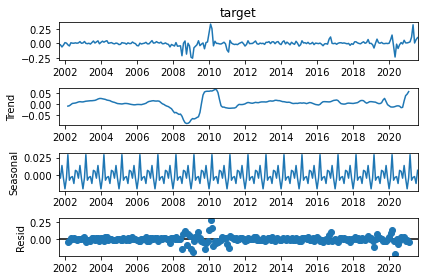

In [22]:
# look at seasonality
decomp_results = seasonal_decompose(target['target'], period = 12)
decomp_results.plot()
plt.show()

In [23]:
# train test split
split_date = pd.Timestamp('2017-01-01')

train = target.loc[:split_date]
y_train = train['target']

test =  target.loc[split_date:]
y_test = test['target']

In [24]:
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic')
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  185
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood                 259.093
Date:                             Mon, 30 Aug 2021   AIC                           -510.186
Time:                                     17:05:59   BIC                           -497.573
Sample:                                          0   HQIC                          -505.069
                                             - 185                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6396      0.033     19.273      0.000       0.575       0.705
ar.S.L12      -0.7138      

In [116]:
sarimax_model = SARIMAX(y_train, 
                order = (0, 0, 1), 
                seasonal_order = (2, 1, [], 12)
                # , exog = x_train
                )

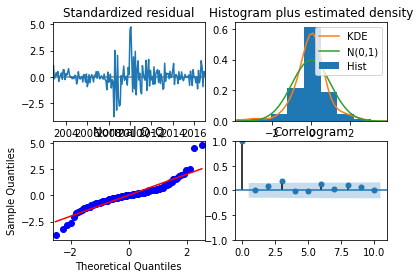

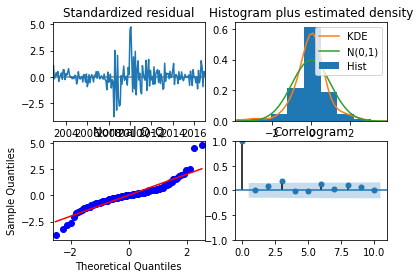

In [117]:
sarimax_mod_fit = sarimax_model.fit()
sarimax_mod_fit.plot_diagnostics()

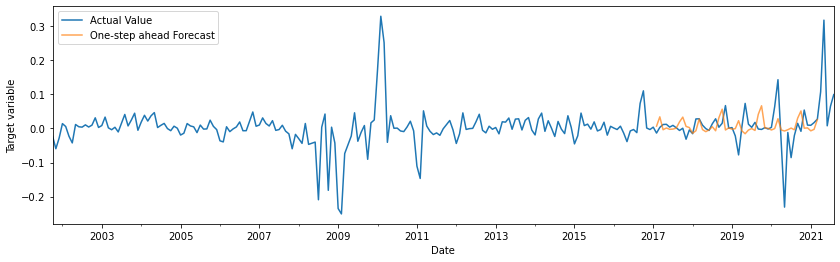

In [118]:
sarimax_pred = sarimax_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1])

sar_pred = sarimax_pred.predicted_mean
sar_pred_ci = sarimax_pred.conf_int()
ax = target.target['2001-10-01':].plot(label='Actual Value')
sar_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.legend()
plt.show()

In [28]:
print("MAPE:", round(mape(y_test, sar_pred), 3))
print("MAE:", round(mae(y_test, sar_pred), 3))

MAPE: 2.44
MAE: 0.035


## Holt Winter’s Exponential Smoothing

In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# fit model
hwes_model = ExponentialSmoothing(y_train, seasonal = 'add', seasonal_periods = 12)
hwes_mod_fit = hwes_model.fit()

# make prediction
hwes_pred = hwes_mod_fit.predict(start = y_test.index[0], end = y_test.index[-1])

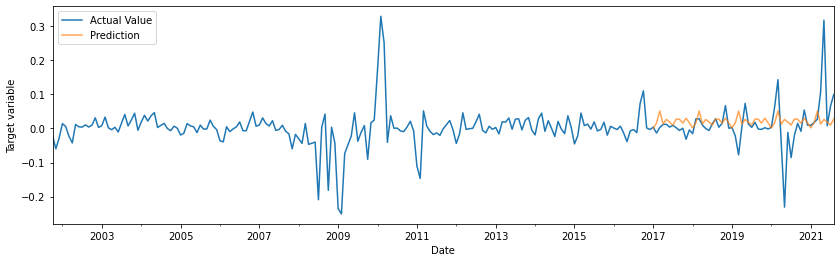

In [30]:
# plot
ax = target.target['2001-10-01':].plot(label='Actual Value')
hwes_pred.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))

ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.legend()
plt.show()

In [31]:
print("MAPE:", round(mape(y_test, hwes_pred), 3))
print("MAE:", round(mae(y_test, hwes_pred), 3))

MAPE: 4.623
MAE: 0.037


## Load exogenous Variables

In [32]:
import quandl
quandl.ApiConfig.api_key = 'AtPuHRXs-rLGozrAYSKk'

fed_funds_data = quandl.get("FRED/FEDFUNDS")

#fed_funds_data = fed_funds_data[fed_funds_data.index >= pd.Timestamp(year=1999, month=9, day=1, hour=0)]

fed_funds_data = fed_funds_data.rename(columns = {"Value":"FED"})

fed_funds_data

,FED
Date,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83
...,...
2021-03-01,0.07
2021-04-01,0.07
2021-05-01,0.06


In [33]:
bci_data = pd.read_csv('BCI_data.csv')

bci_data = bci_data.drop(['LOCATION','INDICATOR','SUBJECT','MEASURE','FREQUENCY','Flag Codes'],axis=1)

bci_data = bci_data.rename(columns = {"TIME": "Date","Value":"BMI"})

bci_data['Date'] = pd.to_datetime(bci_data['Date'])

bci_data.set_index('Date',inplace=True)

#bci_data = bci_data[bci_data.index >= pd.Timestamp(year=1999, month=9, day=1, hour=0)]

bci_data

,BMI
Date,
1950-01-01,101.1842
1950-02-01,101.7680
1950-03-01,102.5461
1950-04-01,103.6547
1950-05-01,104.7723
...,...
2021-03-01,102.1300
2021-04-01,102.0305
2021-05-01,101.8854


In [34]:
pmi_data = quandl.get("ISM/MAN_PMI")

#pmi_data = pmi_data[pmi_data.index >= pd.Timestamp(year=1999, month=9, day=1, hour=0)]

pmi_data

,PMI
Date,
1948-01-01,51.7
1948-02-01,50.2
1948-03-01,43.3
1948-04-01,45.4
1948-05-01,49.5
...,...
2021-03-01,64.7
2021-04-01,60.7
2021-05-01,61.2


In [233]:
unemp_data = quandl.get('FRED/UNRATE')

unemp_data = unemp_data.rename(columns = {"Value":"UNEMP"})

#unemp_data = unemp_data[unemp_data.index >= pd.Timestamp(year=1999, month=9, day=1, hour=0)]

unemp_data

,UNEMP
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
...,...
2021-03-01,6.0
2021-04-01,6.1
2021-05-01,5.8


In [36]:
consumer_conf_data = quandl.get("BCB/4393", collapse='daily')

consumer_conf_data = consumer_conf_data.rename(columns = {"Value":"CON_F"})

#consumer_conf_data = consumer_conf_data[consumer_conf_data.index >= pd.Timestamp(year=1999, month=9, day=1, hour=0)]

consumer_conf_data

,CON_F
Date,
1999-03-31,75.72
1999-04-30,75.86
1999-05-31,77.29
1999-06-30,91.51
1999-07-31,99.11
...,...
2021-03-31,112.90
2021-04-30,104.95
2021-05-31,105.90


In [42]:
from datetime import timedelta
consumer_conf_data.index = (consumer_conf_data.index + timedelta(days=1))

In [43]:
consumer_conf_data

,CON_F
Date,
1999-04-01,75.72
1999-05-01,75.86
1999-06-01,77.29
1999-07-01,91.51
1999-08-01,99.11
...,...
2021-04-01,112.90
2021-05-01,104.95
2021-06-01,105.90


### Joined dataframe

In [62]:
ex_list = [fed_funds_data, consumer_conf_data, pmi_data, bci_data, unemp_data]
ex_merged = reduce(lambda  left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), ex_list)
ex_merged.tail(200)

,FED,CON_F,PMI,BMI,UNEMP
Date,,,,,
2005-01-01,2.28,140.41,56.8,100.79060,5.3
2005-02-01,2.50,145.02,55.5,100.57940,5.4
2005-03-01,2.63,146.48,55.2,100.35030,5.2
2005-04-01,2.79,144.95,52.2,100.10850,5.2
2005-05-01,3.00,141.75,50.8,99.98897,5.1
...,...,...,...,...,...
2021-04-01,0.07,112.90,60.7,102.03050,6.1
2021-05-01,0.06,104.95,61.2,101.88540,5.8
2021-06-01,0.08,105.90,60.6,101.70810,5.9


In [63]:
ex_final = ex_merged
ex_final.columns

Index(['FED', 'CON_F', 'PMI', 'BMI', 'UNEMP'], dtype='object')

In [64]:
# this lags features in ex_columns in the range of periods in lag_periods

ex_columns = ['FED', 'CON_F', 'PMI', 'BMI', 'UNEMP']

lag_periods = list(range(1,13))
def add_lags(var_names, lag_periods):
    for var in var_names:
        for lag in lag_periods:
            var_col = var + '_' + str(lag)
            ex_final[var_col] = ex_final[var].shift(lag)
            
add_lags(ex_final, lag_periods)

In [232]:
# join with target variable
final_df = target.join(ex_final)
final_df.tail(50)

,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,FED_4,...,UNEMP_3,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12
date,,,,,,,,,,,,,,,,,,,,,
2017-07-01,0.009056,1.15,100.06,56.5,100.98090,4.3,1.04,0.91,0.90,0.79,...,4.5,4.4,4.6,4.7,4.7,4.7,4.9,5.0,4.9,4.8
2017-08-01,0.002091,1.16,104.78,59.3,101.25530,4.4,1.15,1.04,0.91,0.90,...,4.4,4.5,4.4,4.6,4.7,4.7,4.7,4.9,5.0,4.9
2017-09-01,-0.005847,1.15,101.48,60.2,101.43810,4.2,1.16,1.15,1.04,0.91,...,4.3,4.4,4.5,4.4,4.6,4.7,4.7,4.7,4.9,5.0
2017-10-01,0.000690,1.15,99.67,58.5,101.40380,4.1,1.15,1.16,1.15,1.04,...,4.3,4.3,4.4,4.5,4.4,4.6,4.7,4.7,4.7,4.9
2017-11-01,-0.031590,1.16,102.81,58.2,101.36940,4.2,1.15,1.15,1.16,1.15,...,4.4,4.3,4.3,4.4,4.5,4.4,4.6,4.7,4.7,4.7
2017-12-01,-0.004323,1.30,103.96,59.3,101.43200,4.1,1.16,1.15,1.15,1.16,...,4.2,4.4,4.3,4.3,4.4,4.5,4.4,4.6,4.7,4.7
2018-01-01,-0.015377,1.41,109.46,59.1,101.48510,4.0,1.30,1.16,1.15,1.15,...,4.1,4.2,4.4,4.3,4.3,4.4,4.5,4.4,4.6,4.7
2018-02-01,0.028015,1.42,116.96,60.7,101.51060,4.1,1.41,1.30,1.16,1.15,...,4.2,4.1,4.2,4.4,4.3,4.3,4.4,4.5,4.4,4.6
2018-03-01,0.028358,1.51,120.57,59.3,101.38400,4.0,1.42,1.41,1.30,1.16,...,4.1,4.2,4.1,4.2,4.4,4.3,4.3,4.4,4.5,4.4


In [66]:
final_df.columns

Index(['target', 'FED', 'CON_F', 'PMI', 'BMI', 'UNEMP', 'FED_1', 'FED_2',
       'FED_3', 'FED_4', 'FED_5', 'FED_6', 'FED_7', 'FED_8', 'FED_9', 'FED_10',
       'FED_11', 'FED_12', 'CON_F_1', 'CON_F_2', 'CON_F_3', 'CON_F_4',
       'CON_F_5', 'CON_F_6', 'CON_F_7', 'CON_F_8', 'CON_F_9', 'CON_F_10',
       'CON_F_11', 'CON_F_12', 'PMI_1', 'PMI_2', 'PMI_3', 'PMI_4', 'PMI_5',
       'PMI_6', 'PMI_7', 'PMI_8', 'PMI_9', 'PMI_10', 'PMI_11', 'PMI_12',
       'BMI_1', 'BMI_2', 'BMI_3', 'BMI_4', 'BMI_5', 'BMI_6', 'BMI_7', 'BMI_8',
       'BMI_9', 'BMI_10', 'BMI_11', 'BMI_12', 'UNEMP_1', 'UNEMP_2', 'UNEMP_3',
       'UNEMP_4', 'UNEMP_5', 'UNEMP_6', 'UNEMP_7', 'UNEMP_8', 'UNEMP_9',
       'UNEMP_10', 'UNEMP_11', 'UNEMP_12'],
      dtype='object')

### Load Short-term model results: one-month prediction

In [98]:
st = pd.read_csv('one_month_prediction.csv')

st = st.rename(columns = {"ds": "date", "yhat":"ST_M1"})

st['date'] = pd.to_datetime(st['date'])

st.set_index('date',inplace=True)

st = st.drop(['Unnamed: 0','y'], axis=1)

st



,ST_M1
date,
1999-03-01,0.120642
1999-04-01,-0.043334
1999-05-01,-0.049121
1999-06-01,-0.182676
1999-07-01,-0.057576
...,...
2020-11-01,0.009809
2020-12-01,-0.000538
2021-01-01,-0.000172


In [231]:
df = st.join(final_df)
df = df[df.index >= pd.Timestamp(year=2001, month=9, day=1, hour=0)]
df.tail(50)

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_3,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12
date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,-0.025190,-0.013539,0.66,102.25,57.6,100.82830,4.6,0.65,0.54,0.41,...,4.7,4.9,5.0,4.9,4.8,4.9,4.8,5.1,5.0,4.9
2017-03-01,-0.005631,0.003131,0.79,113.80,56.6,100.77370,4.4,0.66,0.65,0.54,...,4.7,4.7,4.9,5.0,4.9,4.8,4.9,4.8,5.1,5.0
2017-04-01,0.006791,0.011600,0.90,109.38,55.3,100.60770,4.5,0.79,0.66,0.65,...,4.7,4.7,4.7,4.9,5.0,4.9,4.8,4.9,4.8,5.1
2017-05-01,-0.000079,0.012194,0.91,109.01,55.5,100.60480,4.4,0.90,0.79,0.66,...,4.6,4.7,4.7,4.7,4.9,5.0,4.9,4.8,4.9,4.8
2017-06-01,0.002288,0.003940,1.04,103.49,56.7,100.79300,4.3,0.91,0.90,0.79,...,4.4,4.6,4.7,4.7,4.7,4.9,5.0,4.9,4.8,4.9
2017-07-01,-0.001705,0.009056,1.15,100.06,56.5,100.98090,4.3,1.04,0.91,0.90,...,4.5,4.4,4.6,4.7,4.7,4.7,4.9,5.0,4.9,4.8
2017-08-01,0.006909,0.002091,1.16,104.78,59.3,101.25530,4.4,1.15,1.04,0.91,...,4.4,4.5,4.4,4.6,4.7,4.7,4.7,4.9,5.0,4.9
2017-09-01,-0.017019,-0.005847,1.15,101.48,60.2,101.43810,4.2,1.16,1.15,1.04,...,4.3,4.4,4.5,4.4,4.6,4.7,4.7,4.7,4.9,5.0
2017-10-01,0.007075,0.000690,1.15,99.67,58.5,101.40380,4.1,1.15,1.16,1.15,...,4.3,4.3,4.4,4.5,4.4,4.6,4.7,4.7,4.7,4.9


### Correlation Anlysis: Finding the most predictive variables with lags 

In [102]:
var_corr = (df.corr().sort_values('target'))
var_corr

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_3,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12
FED_12,-0.448706,-0.236427,0.649782,-0.169692,-0.479340,-0.454541,-0.243373,0.695229,0.739081,0.781235,...,-0.348861,-0.384192,-0.414681,-0.443970,-0.468938,-0.489463,-0.510757,-0.533547,-0.563187,-0.587163
FED_11,-0.438275,-0.216309,0.693513,-0.158187,-0.464038,-0.439397,-0.275358,0.737715,0.779904,0.819340,...,-0.380689,-0.412307,-0.441966,-0.468102,-0.489564,-0.509997,-0.532279,-0.557346,-0.574236,-0.587270
FED_10,-0.432411,-0.202673,0.736925,-0.144747,-0.443095,-0.419732,-0.307000,0.779465,0.818915,0.854571,...,-0.409338,-0.440139,-0.466599,-0.489149,-0.510502,-0.531782,-0.556254,-0.568344,-0.574428,-0.584801
FED_9,-0.416492,-0.186652,0.779675,-0.131349,-0.418761,-0.396077,-0.339324,0.819456,0.855080,0.887184,...,-0.437764,-0.465343,-0.488153,-0.510538,-0.532716,-0.555983,-0.567277,-0.568417,-0.571837,-0.580749
FED_8,-0.393940,-0.172286,0.820458,-0.117431,-0.390131,-0.369152,-0.373012,0.856352,0.888377,0.916647,...,-0.463435,-0.487292,-0.509932,-0.533119,-0.557274,-0.567060,-0.567280,-0.565748,-0.567765,-0.574997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PMI_1,0.472883,0.346592,-0.016679,0.094611,0.925134,0.934666,-0.144869,-0.057557,-0.107416,-0.162591,...,0.079190,0.133491,0.175198,0.212223,0.240405,0.253491,0.261395,0.253297,0.249765,0.230101
BMI_1,0.482503,0.356338,-0.000933,0.050072,0.948146,0.972758,-0.163597,-0.046009,-0.096283,-0.148521,...,0.047950,0.110763,0.158026,0.194490,0.220122,0.236136,0.242165,0.240331,0.228947,0.205537
PMI,0.494521,0.357137,-0.057245,0.058814,1.000000,0.974674,-0.107000,-0.106564,-0.160992,-0.210192,...,0.130318,0.172100,0.209689,0.241747,0.257512,0.272149,0.267788,0.272008,0.258225,0.217579
BMI,0.505132,0.359374,-0.043644,0.019289,0.974674,1.000000,-0.110123,-0.093602,-0.145318,-0.193813,...,0.107332,0.154889,0.191857,0.220513,0.238612,0.249469,0.250272,0.244481,0.225353,0.193826


In [101]:
var_corr.head()

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_3,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12
FED_12,-0.448706,-0.236427,0.649782,-0.169692,-0.479340,-0.454541,-0.243373,0.695229,0.739081,0.781235,...,-0.348861,-0.384192,-0.414681,-0.443970,-0.468938,-0.489463,-0.510757,-0.533547,-0.563187,-0.587163
FED_11,-0.438275,-0.216309,0.693513,-0.158187,-0.464038,-0.439397,-0.275358,0.737715,0.779904,0.819340,...,-0.380689,-0.412307,-0.441966,-0.468102,-0.489564,-0.509997,-0.532279,-0.557346,-0.574236,-0.587270
FED_10,-0.432411,-0.202673,0.736925,-0.144747,-0.443095,-0.419732,-0.307000,0.779465,0.818915,0.854571,...,-0.409338,-0.440139,-0.466599,-0.489149,-0.510502,-0.531782,-0.556254,-0.568344,-0.574428,-0.584801
FED_9,-0.416492,-0.186652,0.779675,-0.131349,-0.418761,-0.396077,-0.339324,0.819456,0.855080,0.887184,...,-0.437764,-0.465343,-0.488153,-0.510538,-0.532716,-0.555983,-0.567277,-0.568417,-0.571837,-0.580749
FED_8,-0.393940,-0.172286,0.820458,-0.117431,-0.390131,-0.369152,-0.373012,0.856352,0.888377,0.916647,...,-0.463435,-0.487292,-0.509932,-0.533119,-0.557274,-0.567060,-0.567280,-0.565748,-0.567765,-0.574997


## Shift target variables for 1, 3, 6, 12, 18 months

In [235]:
df_1 = df
df_1 = df_1.reset_index()
df_1['target'] = df_1.target.shift(-1)
df_1['date'] = df_1.date + pd.DateOffset(months = 1)
df_1 = df_1.set_index('date')
df_1 = df_1[df_1.index >= target.index[0]]
df_1['month'] = df_1.index.month
df_1

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12,month
date,,,,,,,,,,,,,,,,,,,,,
2001-10-01,-0.450016,-0.022727,3.07,86.38,46.2,98.18890,5.0,3.65,3.77,3.97,...,4.3,4.4,4.3,4.2,4.2,3.9,3.9,3.9,3.9,10
2001-11-01,-0.414976,-0.059484,2.49,90.74,40.8,97.84437,5.3,3.07,3.65,3.77,...,4.5,4.3,4.4,4.3,4.2,4.2,3.9,3.9,3.9,11
2001-12-01,-0.242129,-0.028155,2.09,80.65,44.1,97.99640,5.5,2.49,3.07,3.65,...,4.6,4.5,4.3,4.4,4.3,4.2,4.2,3.9,3.9,12
2002-01-01,-0.608143,0.014207,1.82,78.31,45.3,98.46352,5.7,2.09,2.49,3.07,...,4.9,4.6,4.5,4.3,4.4,4.3,4.2,4.2,3.9,1
2002-02-01,-0.612288,0.005740,1.73,86.28,47.5,99.11134,5.7,1.82,2.09,2.49,...,5.0,4.9,4.6,4.5,4.3,4.4,4.3,4.2,4.2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-01,0.009809,0.009809,0.09,107.61,57.7,101.26750,6.7,0.09,0.09,0.10,...,10.2,11.1,13.3,14.8,4.4,3.5,3.5,3.6,3.6,12
2021-01-01,-0.000538,0.009312,0.09,111.65,60.5,101.46260,6.7,0.09,0.09,0.09,...,8.4,10.2,11.1,13.3,14.8,4.4,3.5,3.5,3.6,1
2021-02-01,-0.000172,0.017145,0.09,111.71,58.7,101.61790,6.3,0.09,0.09,0.09,...,7.8,8.4,10.2,11.1,13.3,14.8,4.4,3.5,3.5,2


In [236]:
df_3 = df
df_3 = df_3.reset_index()
df_3['target'] = df_3.target.shift(-3)
df_3['date'] = df_3.date + pd.DateOffset(months = 3)
df_3 = df_3.set_index('date')
df_3 = df_3[df_3.index >= target.index[0]]
df_3['month'] = df_3.index.month
df_3

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12,month
date,,,,,,,,,,,,,,,,,,,,,
2001-12-01,-0.450016,-0.028155,3.07,86.38,46.2,98.18890,5.0,3.65,3.77,3.97,...,4.3,4.4,4.3,4.2,4.2,3.9,3.9,3.9,3.9,12
2002-01-01,-0.414976,0.014207,2.49,90.74,40.8,97.84437,5.3,3.07,3.65,3.77,...,4.5,4.3,4.4,4.3,4.2,4.2,3.9,3.9,3.9,1
2002-02-01,-0.242129,0.005740,2.09,80.65,44.1,97.99640,5.5,2.49,3.07,3.65,...,4.6,4.5,4.3,4.4,4.3,4.2,4.2,3.9,3.9,2
2002-03-01,-0.608143,-0.022924,1.82,78.31,45.3,98.46352,5.7,2.09,2.49,3.07,...,4.9,4.6,4.5,4.3,4.4,4.3,4.2,4.2,3.9,3
2002-04-01,-0.612288,-0.042427,1.73,86.28,47.5,99.11134,5.7,1.82,2.09,2.49,...,5.0,4.9,4.6,4.5,4.3,4.4,4.3,4.2,4.2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.009809,0.017145,0.09,107.61,57.7,101.26750,6.7,0.09,0.09,0.10,...,10.2,11.1,13.3,14.8,4.4,3.5,3.5,3.6,3.6,2
2021-03-01,-0.000538,0.027459,0.09,111.65,60.5,101.46260,6.7,0.09,0.09,0.09,...,8.4,10.2,11.1,13.3,14.8,4.4,3.5,3.5,3.6,3
2021-04-01,-0.000172,NaN,0.09,111.71,58.7,101.61790,6.3,0.09,0.09,0.09,...,7.8,8.4,10.2,11.1,13.3,14.8,4.4,3.5,3.5,4


In [237]:
df_6 = df
df_6 = df_6.reset_index()
df_6['target'] = df_6.target.shift(-6)
df_6['date'] = df_6.date + pd.DateOffset(months = 6)
df_6 = df_6.set_index('date')
df_6 = df_6[df_6.index >= target.index[0]]
df_6['month'] = df_6.index.month
df_6

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12,month
date,,,,,,,,,,,,,,,,,,,,,
2002-03-01,-0.450016,-0.022924,3.07,86.38,46.2,98.18890,5.0,3.65,3.77,3.97,...,4.3,4.4,4.3,4.2,4.2,3.9,3.9,3.9,3.9,3
2002-04-01,-0.414976,-0.042427,2.49,90.74,40.8,97.84437,5.3,3.07,3.65,3.77,...,4.5,4.3,4.4,4.3,4.2,4.2,3.9,3.9,3.9,4
2002-05-01,-0.242129,0.011658,2.09,80.65,44.1,97.99640,5.5,2.49,3.07,3.65,...,4.6,4.5,4.3,4.4,4.3,4.2,4.2,3.9,3.9,5
2002-06-01,-0.608143,0.004945,1.82,78.31,45.3,98.46352,5.7,2.09,2.49,3.07,...,4.9,4.6,4.5,4.3,4.4,4.3,4.2,4.2,3.9,6
2002-07-01,-0.612288,0.003891,1.73,86.28,47.5,99.11134,5.7,1.82,2.09,2.49,...,5.0,4.9,4.6,4.5,4.3,4.4,4.3,4.2,4.2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01,0.009809,NaN,0.09,107.61,57.7,101.26750,6.7,0.09,0.09,0.10,...,10.2,11.1,13.3,14.8,4.4,3.5,3.5,3.6,3.6,5
2021-06-01,-0.000538,NaN,0.09,111.65,60.5,101.46260,6.7,0.09,0.09,0.09,...,8.4,10.2,11.1,13.3,14.8,4.4,3.5,3.5,3.6,6
2021-07-01,-0.000172,NaN,0.09,111.71,58.7,101.61790,6.3,0.09,0.09,0.09,...,7.8,8.4,10.2,11.1,13.3,14.8,4.4,3.5,3.5,7


In [238]:
df_12 = df
df_12 = df_12.reset_index()
df_12['target'] = df_12.target.shift(-12)
df_12['date'] = df_12.date + pd.DateOffset(months = 12)
df_12 = df_12.set_index('date')
df_12 = df_12[df_12.index >= target.index[0]]
df_12['month'] = df_12.index.month
df_12

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12,month
date,,,,,,,,,,,,,,,,,,,,,
2002-09-01,-0.450016,0.004232,3.07,86.38,46.2,98.18890,5.0,3.65,3.77,3.97,...,4.3,4.4,4.3,4.2,4.2,3.9,3.9,3.9,3.9,9
2002-10-01,-0.414976,0.009713,2.49,90.74,40.8,97.84437,5.3,3.07,3.65,3.77,...,4.5,4.3,4.4,4.3,4.2,4.2,3.9,3.9,3.9,10
2002-11-01,-0.242129,0.031244,2.09,80.65,44.1,97.99640,5.5,2.49,3.07,3.65,...,4.6,4.5,4.3,4.4,4.3,4.2,4.2,3.9,3.9,11
2002-12-01,-0.608143,0.002959,1.82,78.31,45.3,98.46352,5.7,2.09,2.49,3.07,...,4.9,4.6,4.5,4.3,4.4,4.3,4.2,4.2,3.9,12
2003-01-01,-0.612288,0.008585,1.73,86.28,47.5,99.11134,5.7,1.82,2.09,2.49,...,5.0,4.9,4.6,4.5,4.3,4.4,4.3,4.2,4.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01,0.009809,NaN,0.09,107.61,57.7,101.26750,6.7,0.09,0.09,0.10,...,10.2,11.1,13.3,14.8,4.4,3.5,3.5,3.6,3.6,11
2021-12-01,-0.000538,NaN,0.09,111.65,60.5,101.46260,6.7,0.09,0.09,0.09,...,8.4,10.2,11.1,13.3,14.8,4.4,3.5,3.5,3.6,12
2022-01-01,-0.000172,NaN,0.09,111.71,58.7,101.61790,6.3,0.09,0.09,0.09,...,7.8,8.4,10.2,11.1,13.3,14.8,4.4,3.5,3.5,1


In [239]:
df_18 = df
df_18 = df_18.reset_index()
df_18['target'] = df_18.target.shift(-18)
df_18['date'] = df_18.date + pd.DateOffset(months = 18)
df_18 = df_18.set_index('date')
df_18 = df_18[df_18.index >= target.index[0]]
df_18['month'] = df_18.index.month
df_18

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12,month
date,,,,,,,,,,,,,,,,,,,,,
2003-03-01,-0.450016,0.001855,3.07,86.38,46.2,98.18890,5.0,3.65,3.77,3.97,...,4.3,4.4,4.3,4.2,4.2,3.9,3.9,3.9,3.9,3
2003-04-01,-0.414976,-0.003734,2.49,90.74,40.8,97.84437,5.3,3.07,3.65,3.77,...,4.5,4.3,4.4,4.3,4.2,4.2,3.9,3.9,3.9,4
2003-05-01,-0.242129,0.003505,2.09,80.65,44.1,97.99640,5.5,2.49,3.07,3.65,...,4.6,4.5,4.3,4.4,4.3,4.2,4.2,3.9,3.9,5
2003-06-01,-0.608143,-0.010204,1.82,78.31,45.3,98.46352,5.7,2.09,2.49,3.07,...,4.9,4.6,4.5,4.3,4.4,4.3,4.2,4.2,3.9,6
2003-07-01,-0.612288,0.015541,1.73,86.28,47.5,99.11134,5.7,1.82,2.09,2.49,...,5.0,4.9,4.6,4.5,4.3,4.4,4.3,4.2,4.2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,0.009809,NaN,0.09,107.61,57.7,101.26750,6.7,0.09,0.09,0.10,...,10.2,11.1,13.3,14.8,4.4,3.5,3.5,3.6,3.6,5
2022-06-01,-0.000538,NaN,0.09,111.65,60.5,101.46260,6.7,0.09,0.09,0.09,...,8.4,10.2,11.1,13.3,14.8,4.4,3.5,3.5,3.6,6
2022-07-01,-0.000172,NaN,0.09,111.71,58.7,101.61790,6.3,0.09,0.09,0.09,...,7.8,8.4,10.2,11.1,13.3,14.8,4.4,3.5,3.5,7


### SARIMAX - 1-month Horizon

In [240]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm
from datetime import timedelta
from dateutil.relativedelta import relativedelta

In [241]:
var_corr_1 = (df_1.corr().sort_values('target'))
var_corr_1.head()

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12,month
FED_12,-0.448706,-0.253917,0.649782,-0.169692,-0.479340,-0.454541,-0.243373,0.695229,0.739081,0.781235,...,-0.384192,-0.414681,-0.443970,-0.468938,-0.489463,-0.510757,-0.533547,-0.563187,-0.587163,0.016846
FED_11,-0.438275,-0.237971,0.693513,-0.158187,-0.464038,-0.439397,-0.275358,0.737715,0.779904,0.819340,...,-0.412307,-0.441966,-0.468102,-0.489564,-0.509997,-0.532279,-0.557346,-0.574236,-0.587270,0.014908
FED_10,-0.432411,-0.217603,0.736925,-0.144747,-0.443095,-0.419732,-0.307000,0.779465,0.818915,0.854571,...,-0.440139,-0.466599,-0.489149,-0.510502,-0.531782,-0.556254,-0.568344,-0.574428,-0.584801,0.016289
FED_9,-0.416492,-0.203829,0.779675,-0.131349,-0.418761,-0.396077,-0.339324,0.819456,0.855080,0.887184,...,-0.465343,-0.488153,-0.510538,-0.532716,-0.555983,-0.567277,-0.568417,-0.571837,-0.580749,0.015552
FED_8,-0.393940,-0.187509,0.820458,-0.117431,-0.390131,-0.369152,-0.373012,0.856352,0.888377,0.916647,...,-0.487292,-0.509932,-0.533119,-0.557274,-0.567060,-0.567280,-0.565748,-0.567765,-0.574997,0.010210


In [242]:
var_corr_1.tail()

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12,month
PMI_1,0.472883,0.305273,-0.016679,0.094611,0.925134,0.934666,-0.144869,-0.057557,-0.107416,-0.162591,...,0.133491,0.175198,0.212223,0.240405,0.253491,0.261395,0.253297,0.249765,0.230101,0.024562
BMI_1,0.482503,0.325440,-0.000933,0.050072,0.948146,0.972758,-0.163597,-0.046009,-0.096283,-0.148521,...,0.110763,0.158026,0.194490,0.220122,0.236136,0.242165,0.240331,0.228947,0.205537,0.000307
PMI,0.494521,0.346776,-0.057245,0.058814,1.000000,0.974674,-0.107000,-0.106564,-0.160992,-0.210192,...,0.172100,0.209689,0.241747,0.257512,0.272149,0.267788,0.272008,0.258225,0.217579,0.005200
BMI,0.505132,0.356651,-0.043644,0.019289,0.974674,1.000000,-0.110123,-0.093602,-0.145318,-0.193813,...,0.154889,0.191857,0.220513,0.238612,0.249469,0.250272,0.244481,0.225353,0.193826,-0.021416
target,0.197665,1.000000,-0.019418,-0.000152,0.346776,0.356651,-0.089633,-0.041242,-0.073907,-0.103785,...,0.127993,0.136845,0.152532,0.144309,0.142596,0.143279,0.139634,0.121228,0.107627,0.021881


In [245]:
model_exvar = ['BMI_1', 'PMI_1', 'FED_12','ST_M1']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_1.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_1.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

In [246]:
# Find p, q for sarimax model
#results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
#print(results.summary())

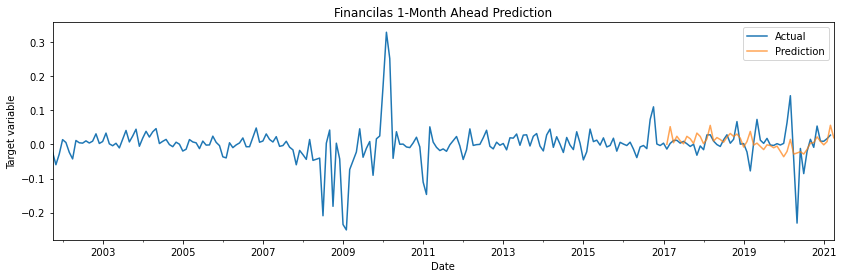

MAPE: 4.102
MAE: 0.028


In [247]:
# use orders from auto arima above
sar1_model = SARIMAX(y_train, 
                order = (1, 0, 1), 
                seasonal_order = (1, 1, 1, 12)
                , exog = x_train
                )

sar1_mod_fit = sar1_model.fit()

sar1_pred = sar1_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

sar1_pred_mean = sar1_pred.predicted_mean
sar1_pred_ci = sar1_pred.conf_int(alpha = 0.5)
ax = df_1.target.plot(label='Actual')
sar1_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Financilas 1-Month Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

print("MAPE:", round(mape(y_test[y_test.index < last_date], sar1_pred_mean[sar1_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar1_pred_mean[sar1_pred_mean.index < last_date]), 3))

### SARIMAX - 3-MONTH HORIZON 

In [248]:
var_corr_3 = (df_3.corr().sort_values('target'))
var_corr_3.head()

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12,month
FED_11,-0.438275,-0.249353,0.693513,-0.158187,-0.464038,-0.439397,-0.275358,0.737715,0.779904,0.819340,...,-0.412307,-0.441966,-0.468102,-0.489564,-0.509997,-0.532279,-0.557346,-0.574236,-0.587270,-0.002885
FED_12,-0.448706,-0.247893,0.649782,-0.169692,-0.479340,-0.454541,-0.243373,0.695229,0.739081,0.781235,...,-0.384192,-0.414681,-0.443970,-0.468938,-0.489463,-0.510757,-0.533547,-0.563187,-0.587163,-0.005280
FED_10,-0.432411,-0.244315,0.736925,-0.144747,-0.443095,-0.419732,-0.307000,0.779465,0.818915,0.854571,...,-0.440139,-0.466599,-0.489149,-0.510502,-0.531782,-0.556254,-0.568344,-0.574428,-0.584801,-0.008974
FED_9,-0.416492,-0.227690,0.779675,-0.131349,-0.418761,-0.396077,-0.339324,0.819456,0.855080,0.887184,...,-0.465343,-0.488153,-0.510538,-0.532716,-0.555983,-0.567277,-0.568417,-0.571837,-0.580749,-0.011591
FED_8,-0.393940,-0.206567,0.820458,-0.117431,-0.390131,-0.369152,-0.373012,0.856352,0.888377,0.916647,...,-0.487292,-0.509932,-0.533119,-0.557274,-0.567060,-0.567280,-0.565748,-0.567765,-0.574997,-0.010464


In [249]:
var_corr_3.tail()

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12,month
PMI_1,0.472883,0.207976,-0.016679,0.094611,0.925134,0.934666,-0.144869,-0.057557,-0.107416,-0.162591,...,0.133491,0.175198,0.212223,0.240405,0.253491,0.261395,0.253297,0.249765,0.230101,0.021292
BMI_1,0.482503,0.220390,-0.000933,0.050072,0.948146,0.972758,-0.163597,-0.046009,-0.096283,-0.148521,...,0.110763,0.158026,0.194490,0.220122,0.236136,0.242165,0.240331,0.228947,0.205537,0.025449
PMI,0.494521,0.264476,-0.057245,0.058814,1.000000,0.974674,-0.107000,-0.106564,-0.160992,-0.210192,...,0.172100,0.209689,0.241747,0.257512,0.272149,0.267788,0.272008,0.258225,0.217579,0.041915
BMI,0.505132,0.274027,-0.043644,0.019289,0.974674,1.000000,-0.110123,-0.093602,-0.145318,-0.193813,...,0.154889,0.191857,0.220513,0.238612,0.249469,0.250272,0.244481,0.225353,0.193826,0.026174
target,0.204323,1.000000,-0.064920,-0.027679,0.264476,0.274027,0.044765,-0.094784,-0.119949,-0.140709,...,0.147689,0.139174,0.137266,0.137782,0.133395,0.114687,0.100983,0.087991,0.073205,0.030262


In [250]:
model_exvar = ['FED_11','BMI_1','PMI_1','ST_M1']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_3.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_3.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

#results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic')
#print(results.summary())

                
sar3_model = SARIMAX(y_train, 
                order = (1, 0, 1), 
                seasonal_order = (1, 1, 1, 12)
                , exog = x_train
                )

sar3_mod_fit = sar3_model.fit()

sar3_pred = sar3_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

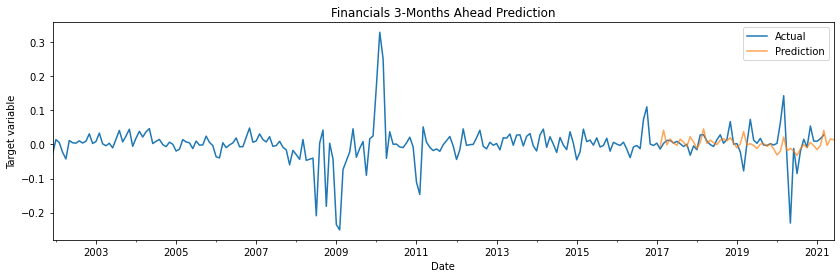

MAPE: 2.899
MAE: 0.027


In [251]:
sar3_pred_mean = sar3_pred.predicted_mean
sar3_pred_ci = sar3_pred.conf_int()
ax = df_3.target.plot(label='Actual')
sar3_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Financials 3-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

print("MAPE:", round(mape(y_test[y_test.index < last_date], sar3_pred_mean[sar3_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar3_pred_mean[sar3_pred_mean.index < last_date]), 3))

### SARIMAX - 6-MONTH HORIZON 

In [252]:
var_corr_6 = (df_6.corr().sort_values('target'))
var_corr_6.head()

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12,month
FED_8,-0.393940,-0.260928,0.820458,-0.117431,-0.390131,-0.369152,-0.373012,0.856352,0.888377,0.916647,...,-0.487292,-0.509932,-0.533119,-0.557274,-0.567060,-0.567280,-0.565748,-0.567765,-0.574997,0.007872
FED_9,-0.416492,-0.259068,0.779675,-0.131349,-0.418761,-0.396077,-0.339324,0.819456,0.855080,0.887184,...,-0.465343,-0.488153,-0.510538,-0.532716,-0.555983,-0.567277,-0.568417,-0.571837,-0.580749,0.005240
FED_7,-0.367501,-0.254971,0.857280,-0.103858,-0.359578,-0.339944,-0.402931,0.889493,0.917656,0.942021,...,-0.508987,-0.532422,-0.557558,-0.567944,-0.566572,-0.564091,-0.561181,-0.561615,-0.567139,-0.000111
FED_10,-0.432411,-0.242241,0.736925,-0.144747,-0.443095,-0.419732,-0.307000,0.779465,0.818915,0.854571,...,-0.440139,-0.466599,-0.489149,-0.510502,-0.531782,-0.556254,-0.568344,-0.574428,-0.584801,-0.004272
FED_6,-0.335509,-0.235894,0.890076,-0.091509,-0.326057,-0.308592,-0.431943,0.918358,0.942617,0.963648,...,-0.531263,-0.556654,-0.567812,-0.566874,-0.562961,-0.559125,-0.554755,-0.553668,-0.556901,-0.005556


In [253]:
var_corr_6.tail()

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12,month
UNEMP_4,0.344885,0.137719,-0.545718,0.533819,0.172100,0.154889,0.748089,-0.552883,-0.558812,-0.563455,...,1.000000,0.931024,0.858327,0.802356,0.753250,0.723527,0.700361,0.694417,0.702955,-0.061491
UNEMP_2,0.330939,0.139266,-0.554363,0.503125,0.074830,0.043559,0.856558,-0.559040,-0.561178,-0.551492,...,0.857376,0.800511,0.749763,0.715500,0.685452,0.666726,0.653585,0.647283,0.654728,-0.028023
UNEMP_1,0.275890,0.147533,-0.556721,0.505343,-0.017793,-0.034531,0.930222,-0.558883,-0.549195,-0.524959,...,0.799839,0.748827,0.713627,0.682654,0.659704,0.643513,0.626930,0.623015,0.630817,0.013511
ST_M1,1.000000,0.183112,-0.151265,0.327164,0.494521,0.505132,0.228250,-0.192488,-0.227764,-0.253947,...,0.344885,0.350511,0.364204,0.373255,0.377797,0.388812,0.398626,0.416320,0.443148,-0.102206
target,0.183112,1.000000,-0.141370,-0.049804,0.097074,0.107837,0.131457,-0.154252,-0.162546,-0.178990,...,0.137719,0.133441,0.114367,0.100816,0.087850,0.072927,0.062739,0.061240,0.054934,0.036759


In [255]:
model_exvar = ['FED_8','ST_M1']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_6.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_6.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

#results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic')
#print(results.summary())

sar6_model = SARIMAX(y_train, 
                order = (1, 0, 1), 
                seasonal_order = (1, 1, 1, 12)
                , exog = x_train
                )

sar6_mod_fit = sar6_model.fit()

sar6_pred = sar6_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test
                                         )

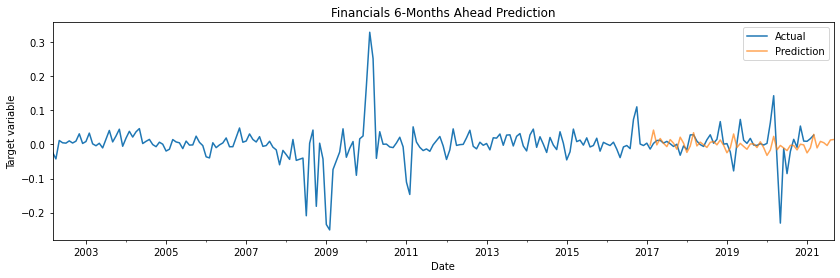

MAPE: 2.965
MAE: 0.029


In [256]:
sar6_pred_mean = sar6_pred.predicted_mean
sar6_pred_ci = sar6_pred.conf_int()
ax = df_6.target.plot(label='Actual')
sar6_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Financials 6-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

print("MAPE:", round(mape(y_test[y_test.index < last_date], sar6_pred_mean[sar6_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar6_pred_mean[sar6_pred_mean.index < last_date]), 3))

### SARIMAX Model - 12 month

In [257]:
var_corr_12 = (df_12.corr().sort_values('target'))
var_corr_12.head()

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12,month
FED_3,-0.253947,-0.268970,0.964627,-0.059101,-0.210192,-0.193813,-0.500807,0.981818,0.994442,1.000000,...,-0.563455,-0.560635,-0.556516,-0.550437,-0.542846,-0.534322,-0.525982,-0.520678,-0.519654,0.029416
FED_2,-0.227764,-0.268530,0.981749,-0.051999,-0.160992,-0.145318,-0.522941,0.994426,1.000000,0.994442,...,-0.558812,-0.554746,-0.549395,-0.542192,-0.532841,-0.523726,-0.514243,-0.507542,-0.505510,0.030263
FED_1,-0.192488,-0.259546,0.994397,-0.049695,-0.106564,-0.093602,-0.547188,1.000000,0.994426,0.981818,...,-0.552883,-0.547604,-0.541155,-0.532200,-0.522391,-0.512197,-0.501545,-0.494112,-0.490282,0.019959
FED_4,-0.279059,-0.253579,0.943754,-0.069003,-0.251398,-0.236198,-0.479528,0.964717,0.981847,0.994456,...,-0.565520,-0.565200,-0.562344,-0.557513,-0.551045,-0.544395,-0.536691,-0.532709,-0.533342,0.019999
FED,-0.151265,-0.238102,1.000000,-0.049682,-0.057245,-0.043644,-0.556865,0.994397,0.981749,0.964627,...,-0.545718,-0.539349,-0.531164,-0.521765,-0.510980,-0.499685,-0.488526,-0.479605,-0.474488,0.012566


In [258]:
var_corr_12.tail()

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12,month
UNEMP_3,0.334139,0.070385,-0.550772,0.519217,0.130318,0.107332,0.799240,-0.556705,-0.561358,-0.563455,...,0.930822,0.857871,0.801277,0.751455,0.718100,0.692246,0.676558,0.673897,0.679103,0.035735
UNEMP_2,0.330939,0.085594,-0.554363,0.503125,0.074830,0.043559,0.856558,-0.559040,-0.561178,-0.551492,...,0.857376,0.800511,0.749763,0.715500,0.685452,0.666726,0.653585,0.647283,0.654728,0.020291
UNEMP_1,0.275890,0.098749,-0.556721,0.505343,-0.017793,-0.034531,0.930222,-0.558883,-0.549195,-0.524959,...,0.799839,0.748827,0.713627,0.682654,0.659704,0.643513,0.626930,0.623015,0.630817,0.004556
UNEMP,0.228250,0.112487,-0.556865,0.520252,-0.107000,-0.110123,1.000000,-0.547188,-0.522941,-0.500807,...,0.748089,0.712665,0.680636,0.656675,0.636084,0.616390,0.602043,0.598483,0.606016,-0.012795
target,-0.042891,1.000000,-0.238102,-0.107601,-0.183902,-0.178830,0.112487,-0.259546,-0.268530,-0.268970,...,0.059492,0.058247,0.051983,0.050909,0.047864,0.044985,0.042895,0.040123,0.043722,0.032514


In [259]:
model_exvar = ['FED_3','ST_M1']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_12.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_12.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

#results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic')
#print(results.summary())

sar12_model = SARIMAX(y_train, 
                order = (1, 0, 1), 
                seasonal_order = (1, 1, 1, 12)
                , exog = x_train
                )

sar12_mod_fit = sar12_model.fit()

sar12_pred = sar12_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test
                                       )

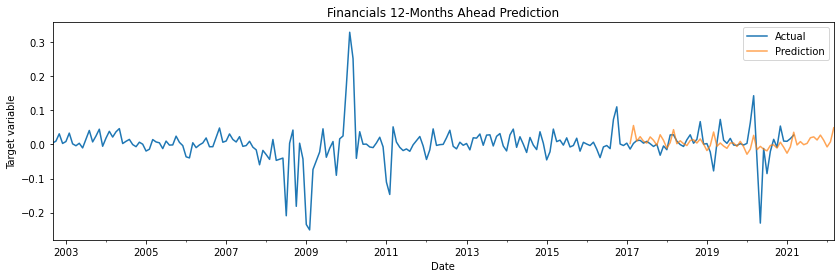

MAPE: 2.887
MAE: 0.028


In [260]:
sar12_pred_mean = sar12_pred.predicted_mean
sar12_pred_ci = sar12_pred.conf_int()
ax = df_12.target.plot(label='Actual')
sar12_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Financials 12-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

print("MAPE:", round(mape(y_test[y_test.index < last_date], sar12_pred_mean[sar12_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar12_pred_mean[sar12_pred_mean.index < last_date]), 3))

### SARIMAX Model - 18-month Horizon

In [261]:
var_corr_18 = (df_18.corr().sort_values('target'))
var_corr_18.head(15)

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12,month
FED_1,-0.192488,-0.244353,0.994397,-0.049695,-0.106564,-0.093602,-0.547188,1.000000,0.994426,0.981818,...,-0.552883,-0.547604,-0.541155,-0.532200,-0.522391,-0.512197,-0.501545,-0.494112,-0.490282,-0.021608
FED,-0.151265,-0.243093,1.000000,-0.049682,-0.057245,-0.043644,-0.556865,0.994397,0.981749,0.964627,...,-0.545718,-0.539349,-0.531164,-0.521765,-0.510980,-0.499685,-0.488526,-0.479605,-0.474488,-0.019016
FED_3,-0.253947,-0.241373,0.964627,-0.059101,-0.210192,-0.193813,-0.500807,0.981818,0.994442,1.000000,...,-0.563455,-0.560635,-0.556516,-0.550437,-0.542846,-0.534322,-0.525982,-0.520678,-0.519654,-0.011453
FED_2,-0.227764,-0.241124,0.981749,-0.051999,-0.160992,-0.145318,-0.522941,0.994426,1.000000,0.994442,...,-0.558812,-0.554746,-0.549395,-0.542192,-0.532841,-0.523726,-0.514243,-0.507542,-0.505510,-0.017938
FED_4,-0.279059,-0.230071,0.943754,-0.069003,-0.251398,-0.236198,-0.479528,0.964717,0.981847,0.994456,...,-0.565520,-0.565200,-0.562344,-0.557513,-0.551045,-0.544395,-0.536691,-0.532709,-0.533342,-0.004793
FED_5,-0.305387,-0.212599,0.919129,-0.079589,-0.289314,-0.274043,-0.457811,0.943460,0.964370,0.981573,...,-0.555663,-0.566898,-0.566589,-0.563079,-0.557856,-0.552579,-0.546800,-0.543627,-0.545837,-0.004971
FED_6,-0.335509,-0.190500,0.890076,-0.091509,-0.326057,-0.308592,-0.431943,0.918358,0.942617,0.963648,...,-0.531263,-0.556654,-0.567812,-0.566874,-0.562961,-0.559125,-0.554755,-0.553668,-0.556901,-0.005556
FED_7,-0.367501,-0.157678,0.857280,-0.103858,-0.359578,-0.339944,-0.402931,0.889493,0.917656,0.942021,...,-0.508987,-0.532422,-0.557558,-0.567944,-0.566572,-0.564091,-0.561181,-0.561615,-0.567139,-0.000111
FED_8,-0.393940,-0.131722,0.820458,-0.117431,-0.390131,-0.369152,-0.373012,0.856352,0.888377,0.916647,...,-0.487292,-0.509932,-0.533119,-0.557274,-0.567060,-0.567280,-0.565748,-0.567765,-0.574997,0.007872
ST_M1,1.000000,-0.127501,-0.151265,0.327164,0.494521,0.505132,0.228250,-0.192488,-0.227764,-0.253947,...,0.344885,0.350511,0.364204,0.373255,0.377797,0.388812,0.398626,0.416320,0.443148,-0.102206


In [262]:
var_corr_18.tail()

,ST_M1,target,FED,CON_F,PMI,BMI,UNEMP,FED_1,FED_2,FED_3,...,UNEMP_4,UNEMP_5,UNEMP_6,UNEMP_7,UNEMP_8,UNEMP_9,UNEMP_10,UNEMP_11,UNEMP_12,month
UNEMP_8,0.377797,0.057399,-0.510980,0.577132,0.272149,0.249469,0.636084,-0.522391,-0.532841,-0.542846,...,0.753250,0.804048,0.860550,0.931961,1.000000,0.933210,0.865371,0.822622,0.796188,0.019432
UNEMP_1,0.275890,0.058028,-0.556721,0.505343,-0.017793,-0.034531,0.930222,-0.558883,-0.549195,-0.524959,...,0.799839,0.748827,0.713627,0.682654,0.659704,0.643513,0.626930,0.623015,0.630817,0.013511
UNEMP,0.228250,0.058556,-0.556865,0.520252,-0.107000,-0.110123,1.000000,-0.547188,-0.522941,-0.500807,...,0.748089,0.712665,0.680636,0.656675,0.636084,0.616390,0.602043,0.598483,0.606016,0.038721
UNEMP_10,0.398626,0.058833,-0.488526,0.602140,0.272008,0.244481,0.602043,-0.501545,-0.514243,-0.525982,...,0.700361,0.731810,0.766402,0.813225,0.865371,0.932474,1.000000,0.932919,0.869483,0.034534
target,-0.127501,1.000000,-0.243093,-0.033619,-0.060646,-0.045572,0.058556,-0.244353,-0.241124,-0.241373,...,0.051059,0.048948,0.052880,0.054394,0.057399,0.055673,0.058833,0.054666,0.048016,0.033309


In [263]:
model_exvar = ['FED_1','ST_M1']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_18.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_18.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

#results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic')
#print(results.summary())

sar18_model = SARIMAX(y_train, 
                order = (1, 0, 1), 
                seasonal_order = (1, 1, 1, 12)
                , exog = x_train
                )

sar18_mod_fit = sar18_model.fit()

sar18_pred = sar18_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test
                                         )

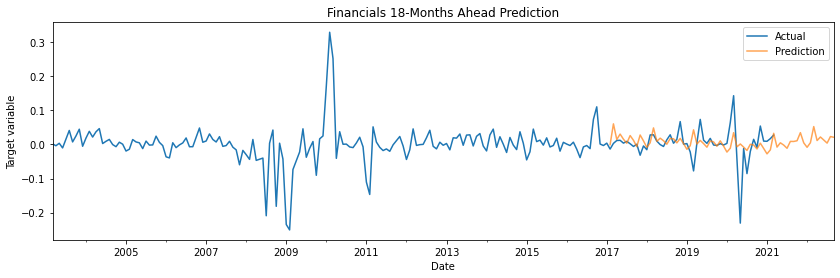

MAPE: 3.539
MAE: 0.029


In [264]:
sar18_pred_mean = sar18_pred.predicted_mean
sar18_pred_ci = sar18_pred.conf_int()
ax = df_18.target.plot(label='Actual')
sar18_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Financials 18-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

print("MAPE:", round(mape(y_test[y_test.index < last_date], sar18_pred_mean[sar18_pred_mean.index < last_date]), 3))
print("MAE:", round(mae(y_test[y_test.index < last_date], sar18_pred_mean[sar18_pred_mean.index < last_date]), 3))

### Future Forecast

In [286]:
pred18 = pd.DataFrame(sar18_pred_mean)
pred18 = pred18.rename(columns = {0: "pred18"})
pred18.index = pred18.index.rename('date')


pred12 = pd.DataFrame(sar12_pred_mean).rename(columns = {0: "pred12"})
pred12.index = pred12.index.rename('date')

pred3 = pd.DataFrame(sar3_pred_mean).rename(columns = {0: "pred3"})
pred3.index = pred3.index.rename('date')

In [289]:
pred_joined = pred18.join(pred12).join(pred3)
pred_joined

,pred18,pred12,pred3
date,,,
2017-02-01,-0.000551,0.002812,-0.005801
2017-03-01,0.060513,0.055644,0.041951
2017-04-01,0.014561,0.009780,-0.001244
2017-05-01,0.030486,0.022911,0.015815
2017-06-01,0.015479,0.009666,0.004601
...,...,...,...
2022-05-01,0.021954,NaN,NaN
2022-06-01,0.013057,NaN,NaN
2022-07-01,0.004006,NaN,NaN


In [290]:
pred_joined['combined_pred'] = pred_joined.pred3.fillna(pred_joined.pred12).fillna(pred_joined.pred18)
pred_joined

,pred18,pred12,pred3,combined_pred
date,,,,
2017-02-01,-0.000551,0.002812,-0.005801,-0.005801
2017-03-01,0.060513,0.055644,0.041951,0.041951
2017-04-01,0.014561,0.009780,-0.001244,-0.001244
2017-05-01,0.030486,0.022911,0.015815,0.015815
2017-06-01,0.015479,0.009666,0.004601,0.004601
...,...,...,...,...
2022-05-01,0.021954,NaN,NaN,0.021954
2022-06-01,0.013057,NaN,NaN,0.013057
2022-07-01,0.004006,NaN,NaN,0.004006


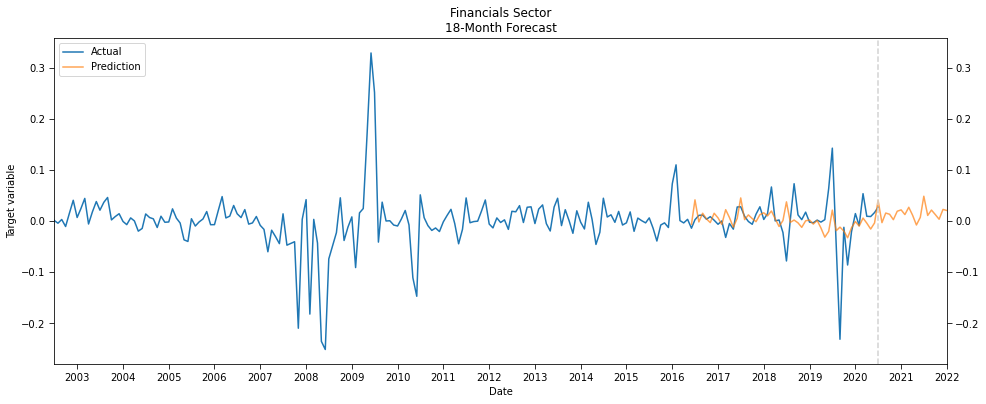

In [292]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# plot inputs
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df_18.index, df_18.target, label = 'Actual')
ax.plot(pred_joined.index, pred_joined.combined_pred, label='Prediction', alpha=.7)
ax.axvline(df_18.dropna().index[-1], c = 'lightgrey', linestyle = '--')

# format the axes
ax.xaxis.set_major_formatter(DateFormatter("%Y")) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 12))

ax.yaxis.set_ticks_position('both')
ax.tick_params(length = 5, axis = 'both', labelright = True, direction = 'out')

ax.margins(x=0) # remove whitespace

# labels
ax.set(xlabel = 'Date', ylabel = 'Target variable', 
       title = 'Financials Sector\n18-Month Forecast')

plt.legend()
plt.show()